## UHI at CPM for evaluation

In [141]:
import valenspy as vp
from dask.diagnostics import ProgressBar

from valenspy.preprocessing_tasks.select import select_point

import warnings
import xarray as xr
import matplotlib.pyplot as plt


# Turn off all warnings
warnings.filterwarnings('ignore')

# define machine name - used for paths of (observational) datasets
machine = 'hortense'

model = "CCLM"

### 0. Settings

In [142]:

experiments = ["BE28_Nukleus", "BE28_Ruben", "BE28_Nick"]
months_to_analyse = [5,6,7,8]
city = "Ghent"


In [143]:
# Define coordinates
coordinates = {
    "Brussels_urban": (4.40, 50.85),
    "Brussels_rural": (4.17, 50.79),
    "Ghent_urban": (3.728, 51.051), # MOCCA Provinciehuis
    "Ghent_rural": (3.816, 50.980) # MOCCA Melle
}


### 1. Function for calculation and plotting

In [144]:
# Calculate UHI, currently only possible with climate grid

def calc_UHI_timeseries(variable: str, ref_dataset: str, experiments: list, urban_coord: tuple, rural_coord:tuple,  months_to_analyse: list, ax=False): 
    # start up input manager
    manager = vp.InputManager(machine=machine)

    if ref_dataset == 'CLIMATE_GRID': 

        # use input manager to load data, defined on settings abov
        ds_obs = manager.load_data(ref_dataset,variable, path_identifiers=['latlon_5km'])

        # select corresponding year
        ds_obs = ds_obs.sel(time = ds_obs.time.dt.year.isin(1995))

        region = 'belgium'

        # select point 
    ds_obs_urban_point = select_point(ds_obs, urban_coord)
    da_obs_urban_point = ds_obs_urban_point[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))

    ds_obs_rural_point = select_point(ds_obs, rural_coord)
    da_obs_rural_point = ds_obs_rural_point[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))

    da_obs_UHI_point = da_obs_urban_point - da_obs_rural_point

    d_da_mod_urban_point = {}
    d_da_mod_rural_point = {}
    d_da_mod_UHI_point = {}
    for experiment in experiments: 

            # define the CCLM files for the corresponding variable
            if variable == "tasmax": 
                daily_statistic = "max"
                variable_mod = "tasmax"

            elif variable == "tasmin": 
                daily_statistic = "min"
                variable_mod = "tas"
            elif variable == "pr": 
                daily_statistic = "sum"
                variable_mod =  variable
            else: 
                daily_statistic = "mean"
                variable_mod = variable

        # load data
            ds_mod = manager.load_data(model, [variable_mod], freq="daily", path_identifiers=[experiment, daily_statistic])
            
            if variable =="tasmax" or variable =="tasmin": 
                ds_mod = ds_mod.rename({'tas':variable}) 

            # do selection
            ds_mod_urban_point = select_point(ds_mod, urban_coord, rotated_pole=True)
            ds_mod_rural_point = select_point(ds_mod, rural_coord, rotated_pole=True)
            da_mod_urban_point = ds_mod_urban_point[variable].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))
            da_mod_rural_point = ds_mod_rural_point[variable].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))
            
            d_da_mod_urban_point[experiment] = da_mod_urban_point
            d_da_mod_rural_point[experiment] = da_mod_rural_point

            d_da_mod_UHI_point[experiment] = da_mod_urban_point - da_mod_rural_point

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
    plt.subplots_adjust(hspace=0.5) 

    # Top plot: UHI
    da_obs_UHI_point.plot(ax=ax1, label = ref_dataset, color='k')
    for experiment in experiments: 
        d_da_mod_UHI_point[experiment].plot(ax=ax1, label = experiment, alpha=0.5)
    ax1.set_ylabel('UHI [°C]')
    ax1.set_title("UHI compared to " + ref_dataset)
    ax1.legend(loc = "center left", bbox_to_anchor = (1,0.5))
    ax1.grid(True)

    # Bottom plots: Temperatures
    da_obs_urban_point.plot(ax=ax2, label = ref_dataset, color='k')
    for experiment in experiments: 
        d_da_mod_urban_point[experiment].plot(ax=ax2, label = experiment, alpha=0.5)
    ax2.set_ylabel("Temperature [°C]")
    ax2.set_title(' ', loc='center')
    ax2.set_title(f"Urban temperatures at ({urban_coord[1]}°N,  {urban_coord[0]}°E)")
    ax2.legend(loc = "center left", bbox_to_anchor = (1,0.5))
    ax2.grid(True)

    da_obs_rural_point.plot(ax=ax3, label = ref_dataset, color='k')
    for experiment in experiments:
        d_da_mod_rural_point[experiment].plot(ax=ax3, label = experiment, alpha=0.5)
    ax3.set_ylabel("Temperature [°C]")
    ax3.set_title(' ', loc='center')
    ax3.set_title(f"Rural temperatures at ({rural_coord[1]}°N,  {rural_coord[0]}°E)")
    ax3.legend(loc = "center left", bbox_to_anchor = (1,0.5))
    ax3.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()



### 2. Calculating UHI

File paths found:
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/CLIMATE_GRID/regridded/latlon_5km/TEMP_MAX_CLIMATE_GRID_1954_2023_daily_latlon_5km.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tasmax']
File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/BE28_Nukleus/T_2M/daily/T_2M_daymax.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/BE28_Ruben/T_2M/daily/T_2M_daymax.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File pat

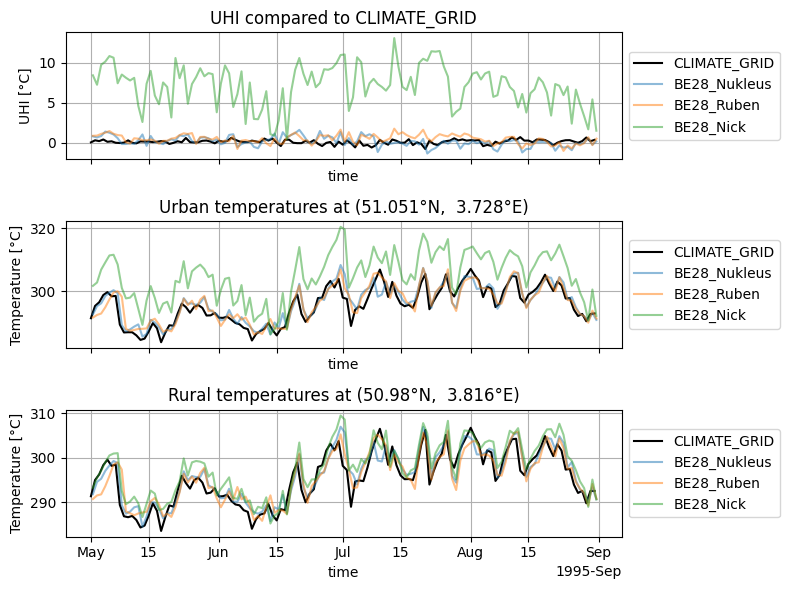

In [145]:
calc_UHI_timeseries(variable = 'tasmax',
                   ref_dataset = "CLIMATE_GRID", 
                    experiments = experiments, 
                    urban_coord = coordinates[city + "_urban"], 
                    rural_coord = coordinates[city + "_rural"],
                    months_to_analyse = months_to_analyse, 
                    ax=False)